# Обучение char-level языковой модели с помощью RNN

Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.5 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данныx

In [ ]:
# Загрузим датасет
dataset = load_dataset('IlyaGusev/gazeta', revision = 'v1.0')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

Dataset gazeta downloaded and prepared to /root/.cache/huggingface/datasets/IlyaGusev___gazeta/default/1.0.0/ef9349c3c0f3112ca4036520d76c4bc1b8a79d30bc29643c6cae5a094d44e457. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
sentences = []

for sentence in tqdm(dataset['validation']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language = 'russian') if len(x) < 128]
        )

  0%|          | 0/5265 [00:00<?, ?it/s]

In [ ]:
len(sentences)

122237

In [ ]:
chars = Counter()

word_threshold = 32

for sentence in tqdm(sentences):   
    for char in sentence:
        chars[char] += 1

  0%|          | 0/122237 [00:00<?, ?it/s]

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_thershold = 500

for char, cnt in chars.items():
  if cnt > counter_thershold:
      vocab.add(char)

In [ ]:
len(vocab)

86

In [ ]:
char2ind = {char: i for i, char in enumerate(vocab)}
ind2char = {i: char for char, i in char2ind.items()}

In [ ]:
class CharDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = char2ind['<unk>']
        self.bos_id = char2ind['<bos>']
        self.eos_id = char2ind['<eos>']
        self.pad_id = char2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id] 
        tokenized_sentence += [char2ind.get(char, self.unk_id) for char in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=char2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2) 

train_dataset = CharDataset(train_sentences)
eval_dataset = CharDataset(eval_sentences)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size = 256) 

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size = 256)

## Архитектура модели

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]      
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

## Train loop


In [ ]:
def evaluate(model, criterion) -> float:
  
    """
    Calculate perplexity on validation dataloader.
    """
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, 
                batch['target_ids'].flatten()
                )
            perplexity.append(torch.exp(loss).item())
    
    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=char2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Обучите модель здесь
num_epoch = 10
losses = []
perplexities = []

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
        optimizer.zero_grad()
        logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
        loss = criterion(
            logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
          
    losses.append(sum(epoch_losses) / len(epoch_losses))
    perplexities.append(evaluate(model, criterion))

Training epoch 0::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/382 [00:00<?, ?it/s]

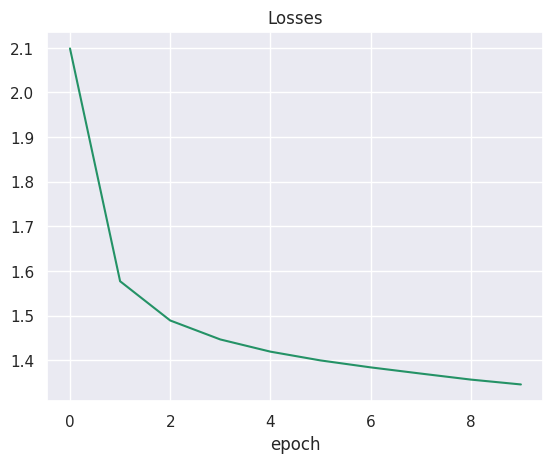

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel('epoch')
plt.show()

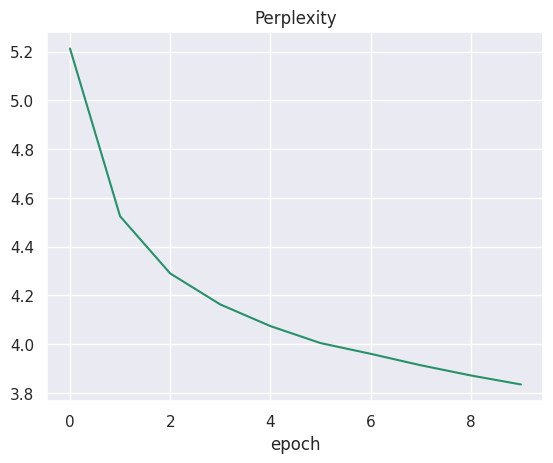

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel('epoch')
plt.show()

## Generation

In [ ]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [char2ind['<bos>']] + [
        char2ind.get(char, char2ind['<unk>']) for char in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == char2ind['<eos>']:
                break
    
    words = ''.join([ind2char[idx.item()] for idx in input_ids])

    return words

In [ ]:
generate_sequence(model, starting_seq='по системе гол плюс пас ')

'<bos>по системе гол плюс пас не принять свои собой в состав россии в состав россии в состав россии в состав россии в состав россии в состав россии в состав р'